In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv("StudentScore20523.xls")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


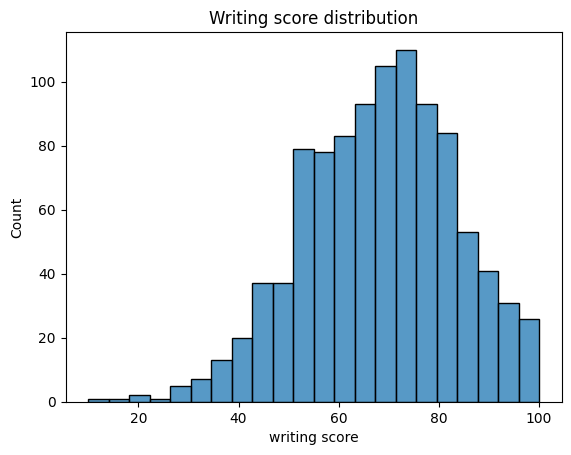

In [3]:
data = pd.read_csv("StudentScore20523.xls")
target = "writing score"
sn.histplot(data["writing score"])
plt.title("Writing score distribution")
plt.savefig("WritingDistribution.png")

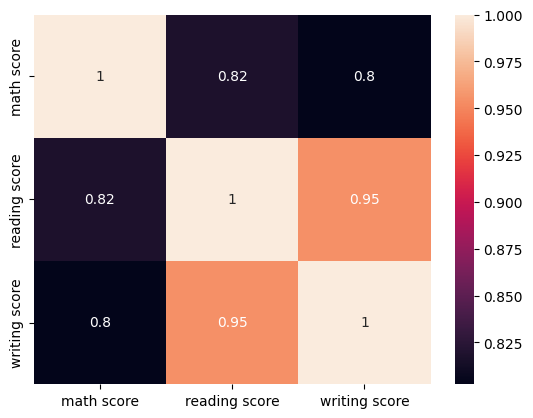

In [4]:
sn.heatmap(data[["math score", "reading score", "writing score"]].corr(),annot= True) 
plt.savefig("Correlation.jpg")


In [5]:
# Chia dữ liệu theo chiều dọc
x = data.drop(target, axis = 1)
y = data[target]


# Chia dữ liệu theo chiều ngang
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

In [6]:
print(x["gender"].unique())
print(x["race/ethnicity"].unique())
print(x["parental level of education"].unique())
print(x["lunch"].unique())
print(x["test preparation course"].unique())


['female' 'male']
['group B' 'group C' 'group A' 'group D' 'group E']
["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
['standard' 'free/reduced']
['none' 'completed']


In [7]:

#Tích hợp bước kiểm tra dữ liệu bị khuyết + tiền xử lí
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # 
    ("scaler", StandardScaler())
])
result1 = num_transformer.fit_transform(x_train[["reading score","math score"]])


In [8]:
education_values = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree",
                    "master's degree"]
gender_values = ["male", "female"]
lunch_values = x_train["lunch"].unique()
test_values = x_train["test preparation course"].unique()
ord_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=[gender_values, education_values, lunch_values, test_values]))
])
result2 = ord_transformer.fit_transform(x_train[["gender","parental level of education","lunch", "test preparation course"]])

In [9]:
nom_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder())
])
result3 = nom_transformer.fit_transform(x_train[["race/ethnicity"]])



In [10]:
preprocessor = ColumnTransformer(transformers=[
    ("num_features", num_transformer, ["reading score", "math score"]),
    ("ordinal_features", ord_transformer, ["gender","parental level of education","lunch", "test preparation course"]),
    ("nominal_features", nom_transformer, ["race/ethnicity"]),
])

In [25]:
reg1 = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("regressor",RandomForestRegressor())
])

# reg.fit(x_train,y_train)
# y_predict = reg.predict(x_test)
# fig, ax = plt.subplots()
# ax.scatter(y_test, y_predict)
# ax.set_title("RandomForestRegressor ")
# ax.set_xlabel("Label value")
# ax.set_ylabel("Predicted value")
# ax.grid()
# plt.show()
# for i,j in zip(y_test,y_predict):
#     print("Actual {} . Predict{}".format(i,j))
# print("MAE {}".format(mean_absolute_error(y_test,y_predict)))
# print("MSE {}".format((mean_squared_error(y_test,y_predict))))
# print("R2 {}".format((r2_score(y_test,y_predict))))
#Tìm tham số tốt nhất 
parameters = {
    "regressor__n_estimators": [50, 100, 200, 500],
    "regressor__criterion": ["squared_error", "absolute_error", "poisson"],
    "regressor__max_depth": [None, 5, 10, 20],
    "regressor__max_features": ["sqrt", "log2"],
}
model1 = GridSearchCV(reg1, param_grid= parameters, scoring  ="r2", cv = 6, verbose = 2,n_jobs=8)
model1.fit(x_train,y_train)
print(model1.best_params_)
print(model1.best_score_)



Fitting 6 folds for each of 96 candidates, totalling 576 fits
{'regressor__criterion': 'poisson', 'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 500}
0.9335751092188839


In [57]:
reg2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", SVR()),   
])
# reg2.fit(x_train,y_train)
# y_predict2 = reg2.predict(x_test)
# fig, ax = plt.subplots()
# ax.scatter(y_test, y_predict1)
# ax.set_title("SVR")
# ax.set_xlabel("Label value")
# ax.set_ylabel("Predicted value")
# ax.grid()
# plt.show()
# for i,j in zip(y_test,y_predict1):
#      print("Actual {} . Predict{}".format(i,j))
# print("MAE {}".format(mean_absolute_error(y_test,y_predict2)))
# print("MSE {}".format((mean_squared_error(y_test,y_predict2))))
# print("R2 {}".format((r2_score(y_test,y_predict2))))

#Tìm bộ tham số tốt nhất
parameters = {
     "regressor__kernel": ["linear","poly","rbf","sigmoid"],
     "regressor__degree": [2,3,4,5,6],
     "regressor__gamma": ["scale","auto"]
}
model2 = GridSearchCV(reg2, param_grid= parameters, scoring  ="r2", cv = 6, verbose = 2,n_jobs=8)
model2.fit(x_train, y_train)
print(model2.best_params_)
print(model2.best_score_)


Fitting 6 folds for each of 40 candidates, totalling 240 fits
{'regressor__degree': 2, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
0.9456824805549274


In [ ]:
reg3 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression()),   
])
reg3.fit(x_train,y_train)
y_predict3 = reg3.predict(x_test)
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict3)
ax.set_title("Linear Regression")
ax.set_xlabel("Label value")
ax.set_ylabel("Predicted value")
ax.grid()
plt.show()
# for i,j in zip(y_test,y_predict2):
#     print("Actual {} . Predict{}".format(i,j))
print("MAE {}".format(mean_absolute_error(y_test,y_predict3)))
print("MSE {}".format((mean_squared_error(y_test,y_predict3))))
print("R2 {}".format((r2_score(y_test,y_predict3))))


In [58]:
reg4 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", KNeighborsRegressor()),   
])

# reg4.fit(x_train,y_train)
# y_predict4 = reg4.predict(x_test)
# fig, ax = plt.subplots()
# ax.scatter(y_test, y_predict4)
# ax.set_title("KNeighborsRegressor")
# ax.set_xlabel("Label value")
# ax.set_ylabel("Predicted value")
# ax.grid()
# plt.show()
# # for i,j in zip(y_test,y_predict1):
# #     print("Actual {} . Predict{}".format(i,j))
# print("MAE {}".format(mean_absolute_error(y_test,y_predict4)))
# print("MSE {}".format((mean_squared_error(y_test,y_predict4))))
# print("R2 {}".format((r2_score(y_test,y_predict4))))

# Tìm bộ parameter tốt nhất
parameters = {
     "regressor__n_neighbors": [5,6,7,8],
     "regressor__algorithm": ["auto","ball_tree"],
     "regressor__leaf_size": [30,60,90],
 }

model4 = GridSearchCV(reg4, param_grid= parameters, scoring  ="r2", cv = 6, verbose = 2,n_jobs=8)
model4.fit(x_train, y_train)
print(model4.best_params_)
print(model4.best_score_)


Fitting 6 folds for each of 24 candidates, totalling 144 fits
{'regressor__algorithm': 'auto', 'regressor__leaf_size': 30, 'regressor__n_neighbors': 7}
0.9055712181840773


In [59]:
reg5 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor",DecisionTreeRegressor()),   
])

# reg5.fit(x_train,y_train)
# y_predict5 = reg5.predict(x_test)
# fig, ax = plt.subplots()
# ax.scatter(y_test, y_predict5)
# ax.set_title("DecisionTreeRegressor")
# ax.set_xlabel("Label value")
# ax.set_ylabel("Predicted value")
# ax.grid()
# plt.show()
# for i,j in zip(y_test,y_predict1):
#      print("Actual {} . Predict{}".format(i,j))
# print("MAE {}".format(mean_absolute_error(y_test,y_predict5)))
# print("MSE {}".format((mean_squared_error(y_test,y_predict5))))
# print("R2 {}".format((r2_score(y_test,y_predict5))))

# Tìm bộ parameter tốt nhất
parameters = {
    "regressor__criterion": ["squared_error", "absolute_error","poisson"],
    "regressor__splitter": ["best","random"],
    "regressor__max_features":["sqrt","log2"]
}
model5 = GridSearchCV(reg5, param_grid= parameters, scoring  ="r2", cv = 6, verbose = 2,n_jobs=8)
model5.fit(x_train, y_train)
print(model5.best_params_)
print(model5.best_score_)


Fitting 6 folds for each of 12 candidates, totalling 72 fits
{'regressor__criterion': 'poisson', 'regressor__max_features': 'sqrt', 'regressor__splitter': 'best'}
0.8274987449913859
